In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df1 = pd.read_csv("../Data/data1.csv")
df2 = pd.read_csv("../Data/data2.csv")

# Prepare data
X1 = df1.loc[:, 'X1':'X24']
y1 = df1['Y(1=default, 0=non-default)']
X2 = df2.loc[:, 'X1':'X14']
y2 = df2['Y(1=default, 0=non-default)']

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

Epoch 1, Loss: 0.6208021573045037
Epoch 51, Loss: 0.433618889613585
Epoch 101, Loss: 0.3010505891659043
Epoch 151, Loss: 0.2533143345605243
Epoch 201, Loss: 0.13638647497546943
Epoch 251, Loss: 0.08818588786843148
Epoch 301, Loss: 0.1048145221376961
Epoch 351, Loss: 0.03993532142009248
Epoch 401, Loss: 0.0641733046663417
Epoch 451, Loss: 0.06482736188495024


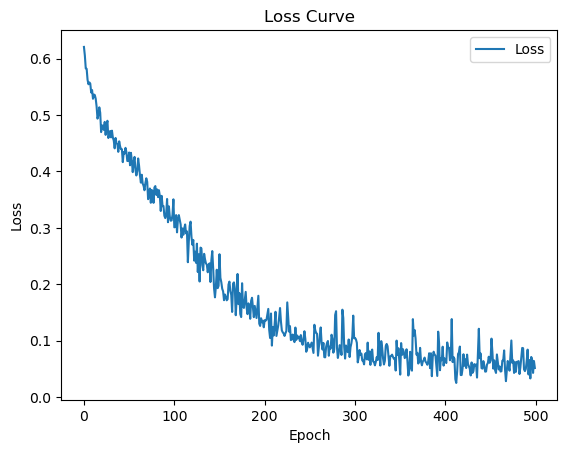

Accuracy: 79.0%


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class BPNN_CBCE(nn.Module):
    def __init__(self, input_features, output_features):
        super(BPNN_CBCE, self).__init__()
        # Define the architecture with 5 hidden layers, each having 256 neurons
        self.fc1 = nn.Linear(input_features, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.output_layer = nn.Linear(256, output_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

def train_model(model, criterion, optimizer, train_loader, epochs=500, history=None):
    # Training loop
    model.train()
    if history is None:
        history = {'loss': []}
    for epoch in range(epochs):
        running_loss = 0.0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        history['loss'].append(epoch_loss)
        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    return history


def evaluate_model(model, test_loader):
    # Evaluation loop
    model.eval()
    total = correct = 0
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

# Example usage
input_features = 24  # Set to the number of your input features
output_features = 2  # Set for binary classification (change if necessary)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Data preparation (dummy data)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, loss, and optimizer setup
model = BPNN_CBCE(input_features, output_features)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model and keep track of the loss
history = train_model(model, criterion, optimizer, train_loader, epochs=500)

# plt.figure(figsize=(20, 17))
# Plot the loss curve
plt.plot(history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()
evaluate_model(model, test_loader)
